# CS 6320 Project 2: Detecting Lines and Circles using Hough Transform

A notebook contains many blocks of code, each of which can be run independently. You can run a cell with ctrl+enter or shift+enter (to move to the next cell).


You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points.

## Brief
    Hand-in: through Gradescope
    Required files: <your_uid>.zip.(Please begin with 'u' for your uid)
<!---<your_uid>_proj1.pdf--> 


## Setup

   0. Unzip proj2_6320.zip and go to proj2_6320 directory.
      - You can run `unzip proj2_6320.zip && cd proj2_6320` in your terminal.
   1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
   2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj2_env_<OS>.yml`.
    - NOTE that proj2_env.yml is inside the project folder.
   3. This should create an environment named ‘proj2’. Activate it using the Windows command, activate proj2 or the MacOS / Linux command, source activate proj2
   4. Run the notebook using `jupyter notebook` under *proj2_6320* directory.
   5. Ensure that all sanity checks are passing by running pytest tests inside the repo folder.
   6. Generate the zip folder for the code portion of your submission once you’ve finished the project using 
    
        `python zip_submission.py --uid <your_uid>` 


## Library Functions
Do not use any library functions that implement Hough Transform in your solution. You can use functions to perform fitlering etc.

## Debugging
We have included several synthetic images of lines and circles to help test your methods in simpler domains if you'd like.

## Writeup
For this project, this notebook itself is the report. You must run all your cells before you hand in it. You code, results, visualization, and discussion will be used for the grading. You will be deducted points if the results are not shown in this notebook. Do not change the order of the cells. You can add cells in need. You can copy a cell and run it seperately if you need to run a cell multiple times and thus every result is displayed in the cell.


## Rubric
    +26 pts: Ques_1
    +12 pts: Ques_2
    +15 pts: Ques_3
    +17 pts: Ques_4
    +15 pts: Ques_5
    +15 pts: Ques_6

    Distribution of the points in a Question is separately mentioned for each sub-task

    -5*n pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.
    
Submission Format

This is very important as you will lose 5 points for every time you do not follow the instructions. You will attach two items in your submission on Canvas:

1. <your_uid>.zip containing:
    - proj2_code/ - directory containing all your code for this assignment
    - data/       - directory containing all the input images
    - results/    - directory containing all your output images

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --uid <your_uid> (it will zip up the appropriate directories/files for you!)

In [62]:
import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import math

### 1 Processing an image to detect lines using Hough Transform (26 points)

In this question, we process an image and apply Hough Transform on the processed image

#### Tasks:
1. Compute a smooth version of the Input Image <b>(4 points)</b>
2. Detect edges from Images <b>(6 points)</b>
3. Implement Hough Transform <b>(8 points)</b>
4. Apply Hough Transform to detect lines from images <b>(4 points)</b>
5. Apply Hough Transform to detect edges from images <b>(4 points)</b>

#### 1.1 Compute a smooth version of the Input Image

##### You should use a Gaussian filter to generate a smooth image 

##### Please note:
The function takes in as input only the sigma value (integer only).<br>
The size of the filter should be computed using the sigma value

In [63]:
def Gaussian_Filter(sigma):
    '''
    The function takes in as input only the sigma
    and generates a filter using the sigma value
    The size of the filter should be computed using the sigma value
    '''
    ##############################
    # TO DO: Your Implementation
    ##############################
    def iso_gaussian(x,y):
        norm = (1.0/(2.0*np.pi*sigma**2))
        exp_term = np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
        return norm*exp_term
    
    n = math.ceil(sigma*3) + int(math.modf(sigma/2)[1] > 0)# need filter size to be about 3 times standard deviation (odd size)
    n_half = math.floor(n/2)
    
    gaussian_filt = np.array([iso_gaussian(i,j) for i in range(-n_half, n_half+1) for j in range(-n_half, n_half+1)]).reshape(n,n)
    g_sum = np.sum(gaussian_filt)
    g_kernel = (1.0/g_sum)*gaussian_filt
    return g_kernel

# Applys gaussian kernel on image via convolution operation.
def blur_img(img, sigma):
    return cv.filter2D(img, -1, Gaussian_Filter(sigma=sigma))

    ################################
    # Your Implementation ENDS here
    ################################

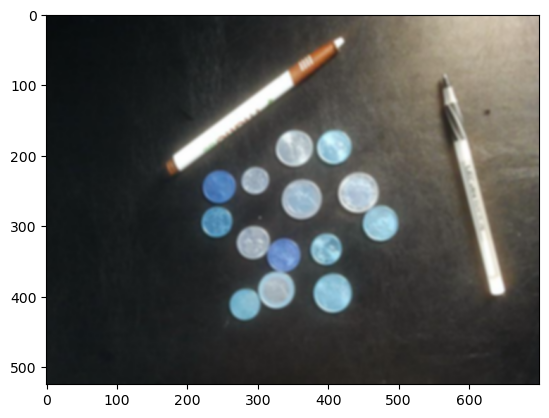

In [64]:
# Reading the Input Image
img        = cv.imread('../data/proj2-clean-image.jpg')

# Generates the Gaussian Filter
g_kernel   = Gaussian_Filter(2)

# Smoothing the image with the Gaussian Filter
smooth_img = cv.filter2D(img, -1, g_kernel)

# Saves the Smooth Image in the result directory
cv.imwrite("../results/Ques_1/proj2-clean-image-smoothed.png", smooth_img)

# Plots the smoothed image in the notebook
plt.figure(); plt.imshow(smooth_img.astype(np.uint8));

In [65]:
def rgb2gray(rgb):
    '''
    Converts the RGB image to the Gray Scale
    '''

    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [66]:
def image_uint(input_arr):
    '''
    Scales the image intensity values to the range [0, 255]
    '''

    return (255.0*(input_arr - np.min(input_arr))/(np.max(input_arr) - np.min(input_arr))).astype(np.uint8)

In [67]:
# Displays input image.
def disp_img(img):
    plt.figure(); plt.imshow(img.astype(np.uint8), cmap='gray') if len(img.shape) < 3 else \
        plt.figure(); plt.imshow(smooth_img.astype(np.uint8));

#### 1.2 Edge Detector
Now we need to extract the edges from the input images. This is as essential step towards detection of lines and circles from the image.

#### You should define a Sobel filter to detect edges in the Original and Smooth Image
Following the definition of the filter, you convolve the filter over the input image using OpenCV library function, <b>filter2D()</b>. You are not required to write any convolution function to apply the filter.

You are required to detect edges on both the <b>original</b> and <b>smooth</b> images.

<b>Do you observe any difference between them? Please comment in a separate cell.</b>

#### 1.2.1 Edge Detector on the Original Image
Please remember the edge detection method should be applied on <b>gray images</b>.
The edge image should be saved as <b>img_gray_edge</b>.

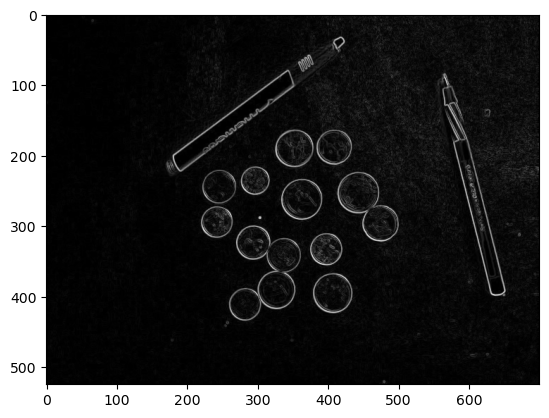

In [106]:
##############################
# TO DO: Your Implementation
##############################

# returns sobel kernels in x and y.
def sobel_kernel():
    sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sy = sx.T
    
    return sx, sy
# returns sobel filtered image.
def sobel_detect_edge(img):
    sx, sy = sobel_kernel()
    Gx, Gy = cv.filter2D(img, -1, sx), cv.filter2D(img, -1, sy)
    img_gray_edge = image_uint(np.sqrt(Gx**2 + Gy**2))
    return cv.convertScaleAbs(img_gray_edge)

img_og_gray = rgb2gray(np.copy(img))
img_gray_edge = sobel_detect_edge(np.copy(img_og_gray))

################################
# Your Implementation ENDS here
################################

# Save the Image
cv.imwrite('../results/Ques_1/Ori_Clean_Edge_Image.png', img_gray_edge)

#Plot the Image
plt.figure(); plt.imshow(img_gray_edge.astype(np.uint8), cmap='gray');

#### 1.2.2 Edge Detector on the Smooth Image
Please remember the edge detection method should be applied on <b>gray images</b>.
The edge image should be saved as <b>smooth_img_gray_edge</b>.

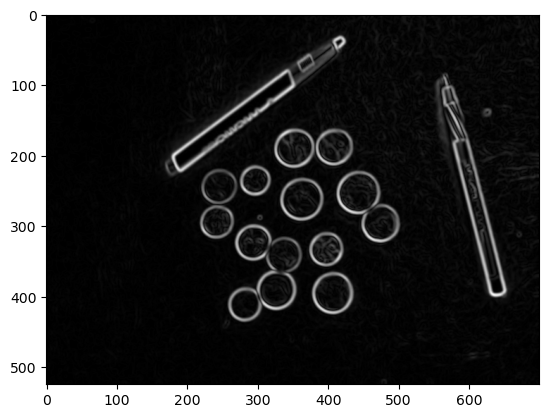

In [107]:
##############################
# TO DO: Your Implementation
##############################
def edge_detector(in_img, sigma, blur=True):
    
    img_smooth_gray = rgb2gray(blur_img(img=in_img, sigma=sigma)) if blur else \
        rgb2gray(in_img)
    smooth_img_gray_edge = sobel_detect_edge(img_smooth_gray)
    return smooth_img_gray_edge

smooth_img_gray_edge = edge_detector(img, 2)
################################
# Your Implementation ENDS here
################################

# Save the Image
cv.imwrite('../results/Ques_1/Smooth_Clean_Edge_Image.png', smooth_img_gray_edge)

#Plot the Image
plt.figure(); plt.imshow(smooth_img_gray_edge.astype(np.uint8), cmap='gray');

1.2-Response: The smooth image has more noticeable edges than the original image as a result of having less noise from the background.

#### 1.3 Hough Transform to detect Lines
In this exercise you are expected to implement Hough Transform for line detection as discussed in class. Hough Transform uses an accumulator array to capture the lines present in image. It is applied on binary images which can be generated by thresholding the edge detector output.<br>

For this exercise, the range of theta is <b>[-90, 90]</b> and the range of rho is <b>[-img_diag, img_diag]</b>.

In [168]:
def hough_transform(input_img, threshold, theta_res, rho_res):

    '''
    This function computes the Accumulator array
    
    Input:
    1. Output of the Edge Detection Method
    2. Threshold value for generating the binary image
    3. Resolution for Angle
    4. Resolution for Perpendicular Distance from the Origin (Rho)
    
    Output:
    1. Accumulator array       , declare as accumulator
    2. Array of Theta          , declare as thetas
    3. Array of Rho            , declare as rhos
    4. Thresholded Binary Image, declare as binary_img

    '''

    ##############################
    # TO DO: Your Implementation
    ##############################
    thetas = np.deg2rad(np.arange(theta_res[0], theta_res[1]))
    cos_t, sin_t = np.cos(thetas), np.sin(thetas)
    rhos = np.linspace(rho_res[0], rho_res[1], rho_res[1]*2)

    sz_y, sz_x = input_img.shape
    
    accumulator = np.zeros((2*rho_res[1], len(thetas)), dtype=np.uint32)
    binary_img = np.uint8((input_img >= threshold))
    
    edge_pts = {(i, j) if binary_img[j,i] else None \
        for i in range(sz_x) for j in range(sz_y)}
    edge_pts.remove(None)
    
    for edge_pt in edge_pts:
        for t_idx in range(len(thetas)):
            d = round(edge_pt[0]*cos_t[t_idx]-edge_pt[1]*sin_t[t_idx])
            accumulator[d, t_idx] += 1
    
    ################################
    # Your Implementation ENDS here
    ################################

    return accumulator, thetas, rhos, binary_img

#### 1.3.1 Hough Transform to detect Lines from Original Image

Use the edges detected from the <b>original input image</b> to apply Hough Transform function.<br>
<br>

You need to find a resaonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract lines. Please discuss the effect of the threshold on the performance of the algorithm.

Plot the Accumulator Array using the matplotlib function, figure size (20, 20), with proper labeling and title. The image should be saved as <b>Ori_Clean_Image_Accumulator_Array.png</b> in results/Ques_1 sub-directory.


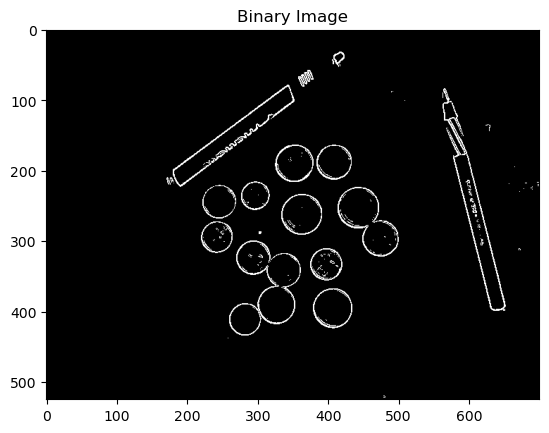

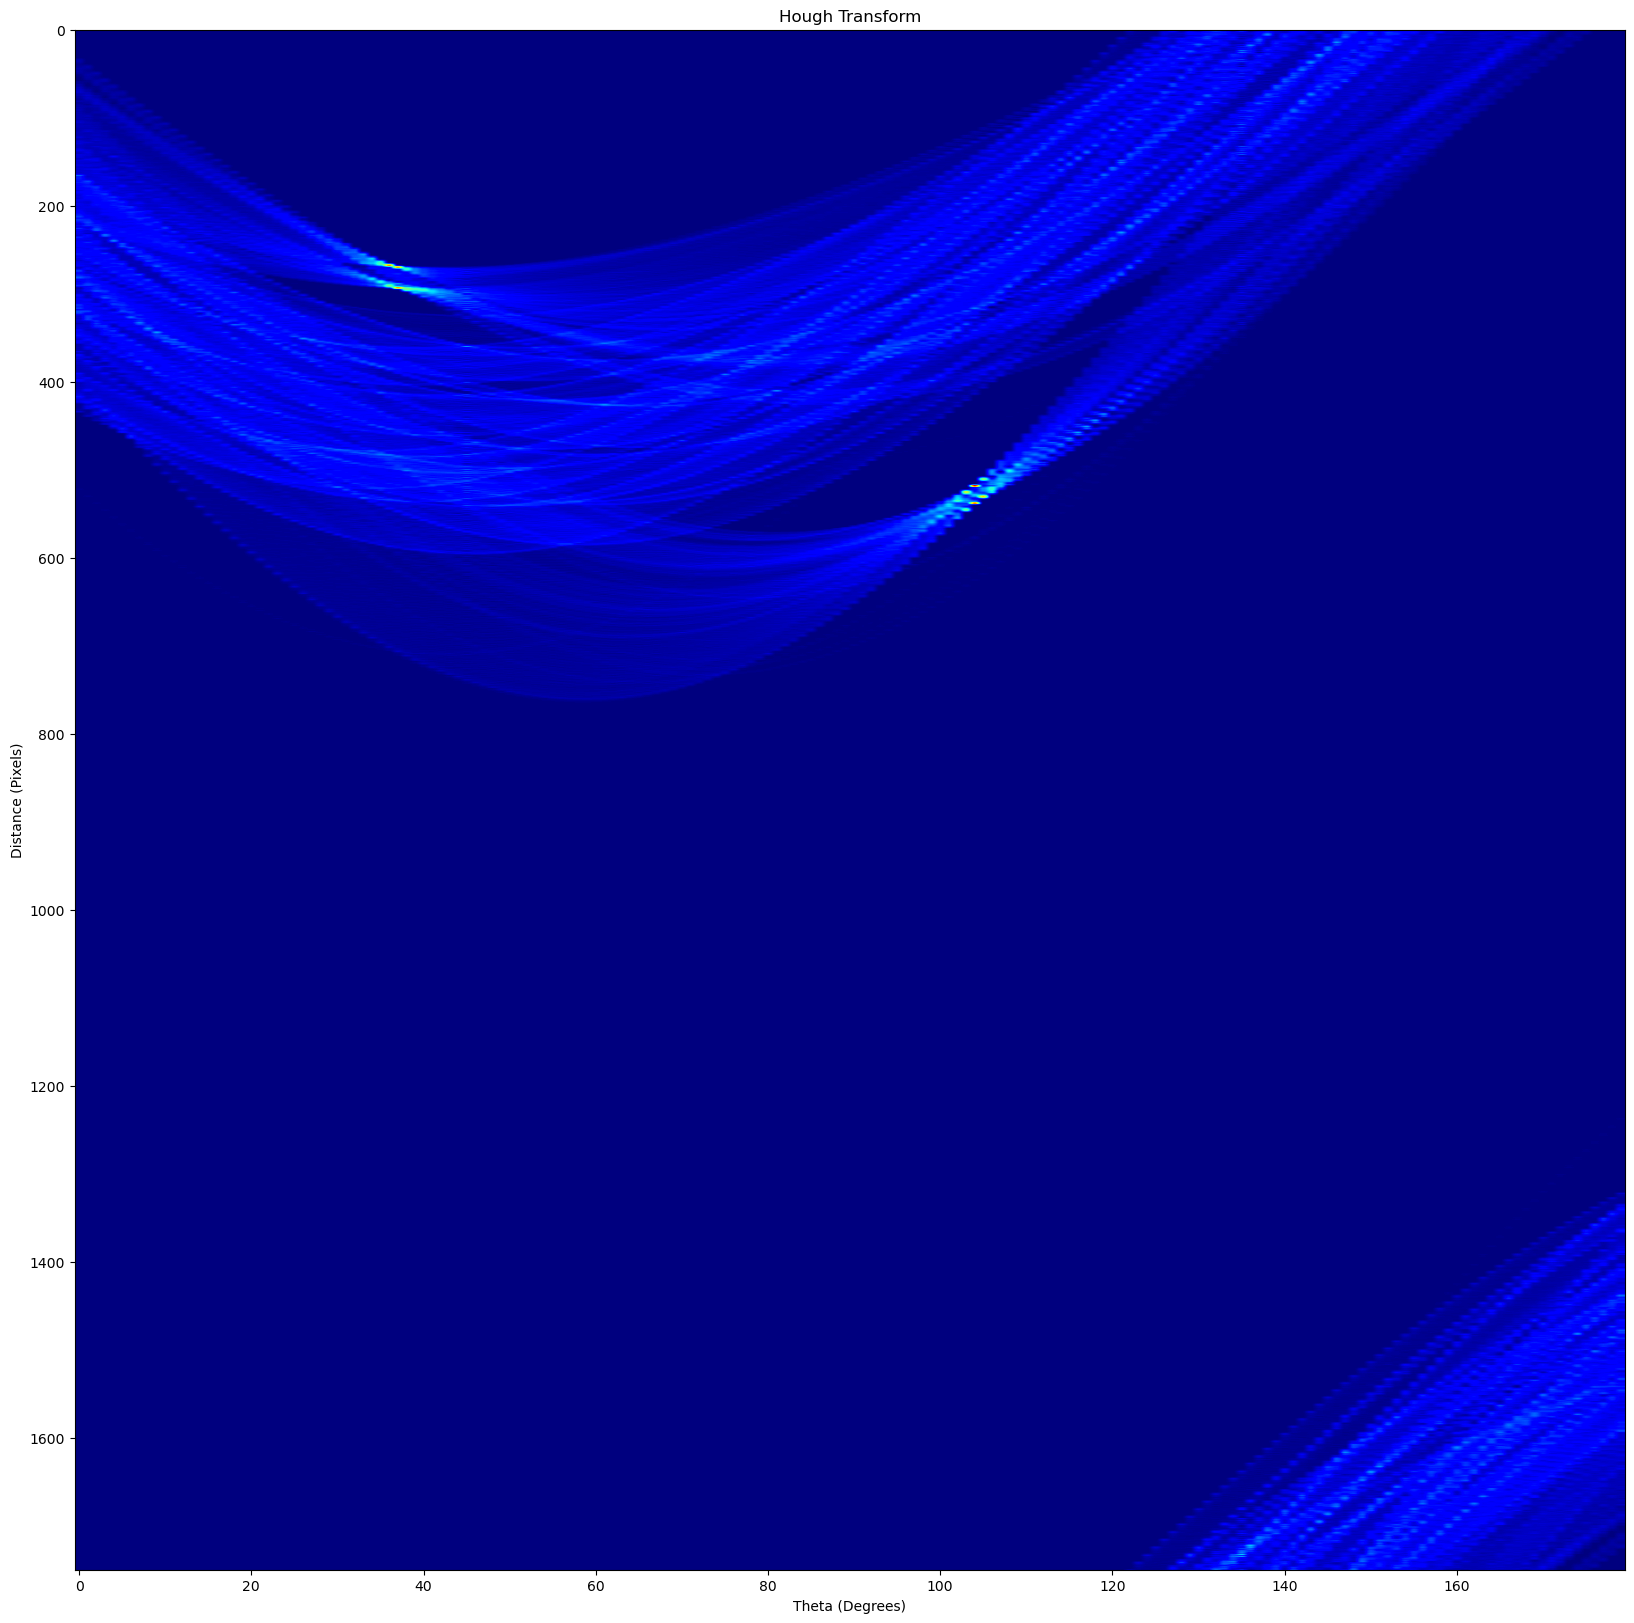

In [169]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract the lines
# To expedite the process you can play with the resolution of the theta and rho 
# without compromising the quality of the results
diag_len = math.ceil(np.sqrt(img.shape[0]**2+img.shape[1]**2))
ori_accumulator, ori_thetas, ori_rhos, ori_binary_img = hough_transform(edge_detector(np.copy(img), 2, blur=False), np.mean(img), [-90, 90], [-diag_len, diag_len])

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_1/Ori_Clean_Binary_Image.png', ori_binary_img)

#Plot the Binary Image
plt.figure(); plt.imshow(ori_binary_img.astype(np.uint8), cmap='gray'); plt.title('Binary Image')


# Plot Accumulator Array
##############################
# TO DO: Your Implementation
##############################
def plot_accum_arr(accumulator, save_path):
    fig = plt.figure(figsize=(20,20))
    
    plt.imshow(accumulator, aspect='auto', cmap='jet')
    plt.title("Hough Transform")
    plt.xlabel("Theta (Degrees)"); plt.ylabel("Distance (Pixels)")
    cv.imwrite(save_path, (accumulator/np.max(accumulator)))
    return fig

arr_fig = plot_accum_arr(ori_accumulator, \
                    '../results/Ques_1/Ori_Clean_Image_Accumulator_Array.png')
################################
# Your Implementation ENDS here
################################

For plotting lines (infinite) in the images, you should use the OpenCV <b>line</b> function which can hold all the lines and then you could overlay them on the input image.

In [146]:
def plot_lines(img_path, accumulator, thetas, rhos, acc_threshold, save_path):

    '''
    This function plots infinite lines
    This should be used to draw lines along the boundary of the pens
    
    Input:
    1. RGB Image for plotting lines
    2. Accumulator array
    3. Vector of the angle values
    4. Vector of the rho valueOpenCV
    Saves the output image in save_path
    '''

    ##############################
    # TO DO: Your Implementation
    ##############################
    img = cv.imread(img_path)
    m = 1000
    
    acc_threshold_vals = np.int32(accumulator >= acc_threshold)*accumulator
    max_idxs = np.argmax(acc_threshold_vals, 0)
    nz_idxs = np.nonzero(max_idxs)[0]
    for t_idx in nz_idxs:
        rho, theta = rhos[max_idxs[t_idx]], thetas[t_idx]   
        
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        x0, y0 = cos_t*rho, sin_t*rho
        pt0, pt1 = (round(x0 + -sin_t*m), round(y0 + cos_t*m)), (round(x0 + sin_t*m), round(y0 - cos_t*m))
        cv.line(img, pt0, pt1, (0, 255, 0), 1)
        
    plt.figure();plt.imshow(img, aspect='auto')
    cv.imwrite(save_path, img)
    # print(rhos[max_idxs[nz_idxs]])
    ################################
    # Your Implementation ENDS here
    ################################

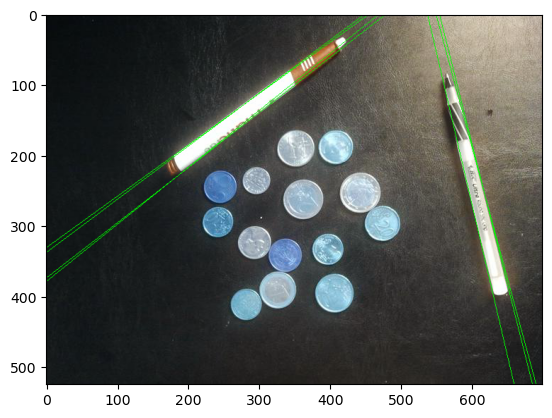

In [152]:
# Plot the Lines extracted on the Original Image
# Play with the Accumulator Thresholding to get rid of the unwanted lines
acc_threshold = np.max(ori_accumulator)*0.45
plot_lines('../data/proj2-clean-image.jpg', ori_accumulator, ori_thetas, ori_rhos, acc_threshold, save_path='../results/Ques_1/Ori_Clean_Image_Output_Lines.png')

#### 1.3.2 Hough Transform to detect Lines from the Smooth Image

Use the edges detected from the <b>smooth input image</b> to apply Hough Transform function.<br>
<br>

You need to find a resaonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract lines. Please discuss the effect of the threshold on the performance of the algorithm.

Plot the Accumulator Array using the matplotlib function, figure size (20, 20), with proper labeling and title. The image should be saved as <b>Smooth_Clean_Image_Accumulator_Array.png</b> in results directory.

Response: The more exclusive our threshold or rather the more we ignore irrelevant edges 
the faster the hough transform processes the accumulator.


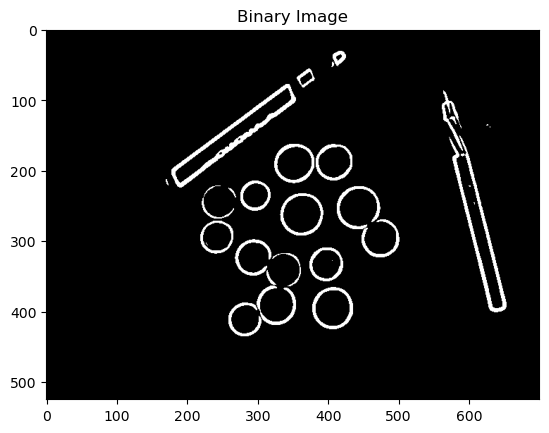

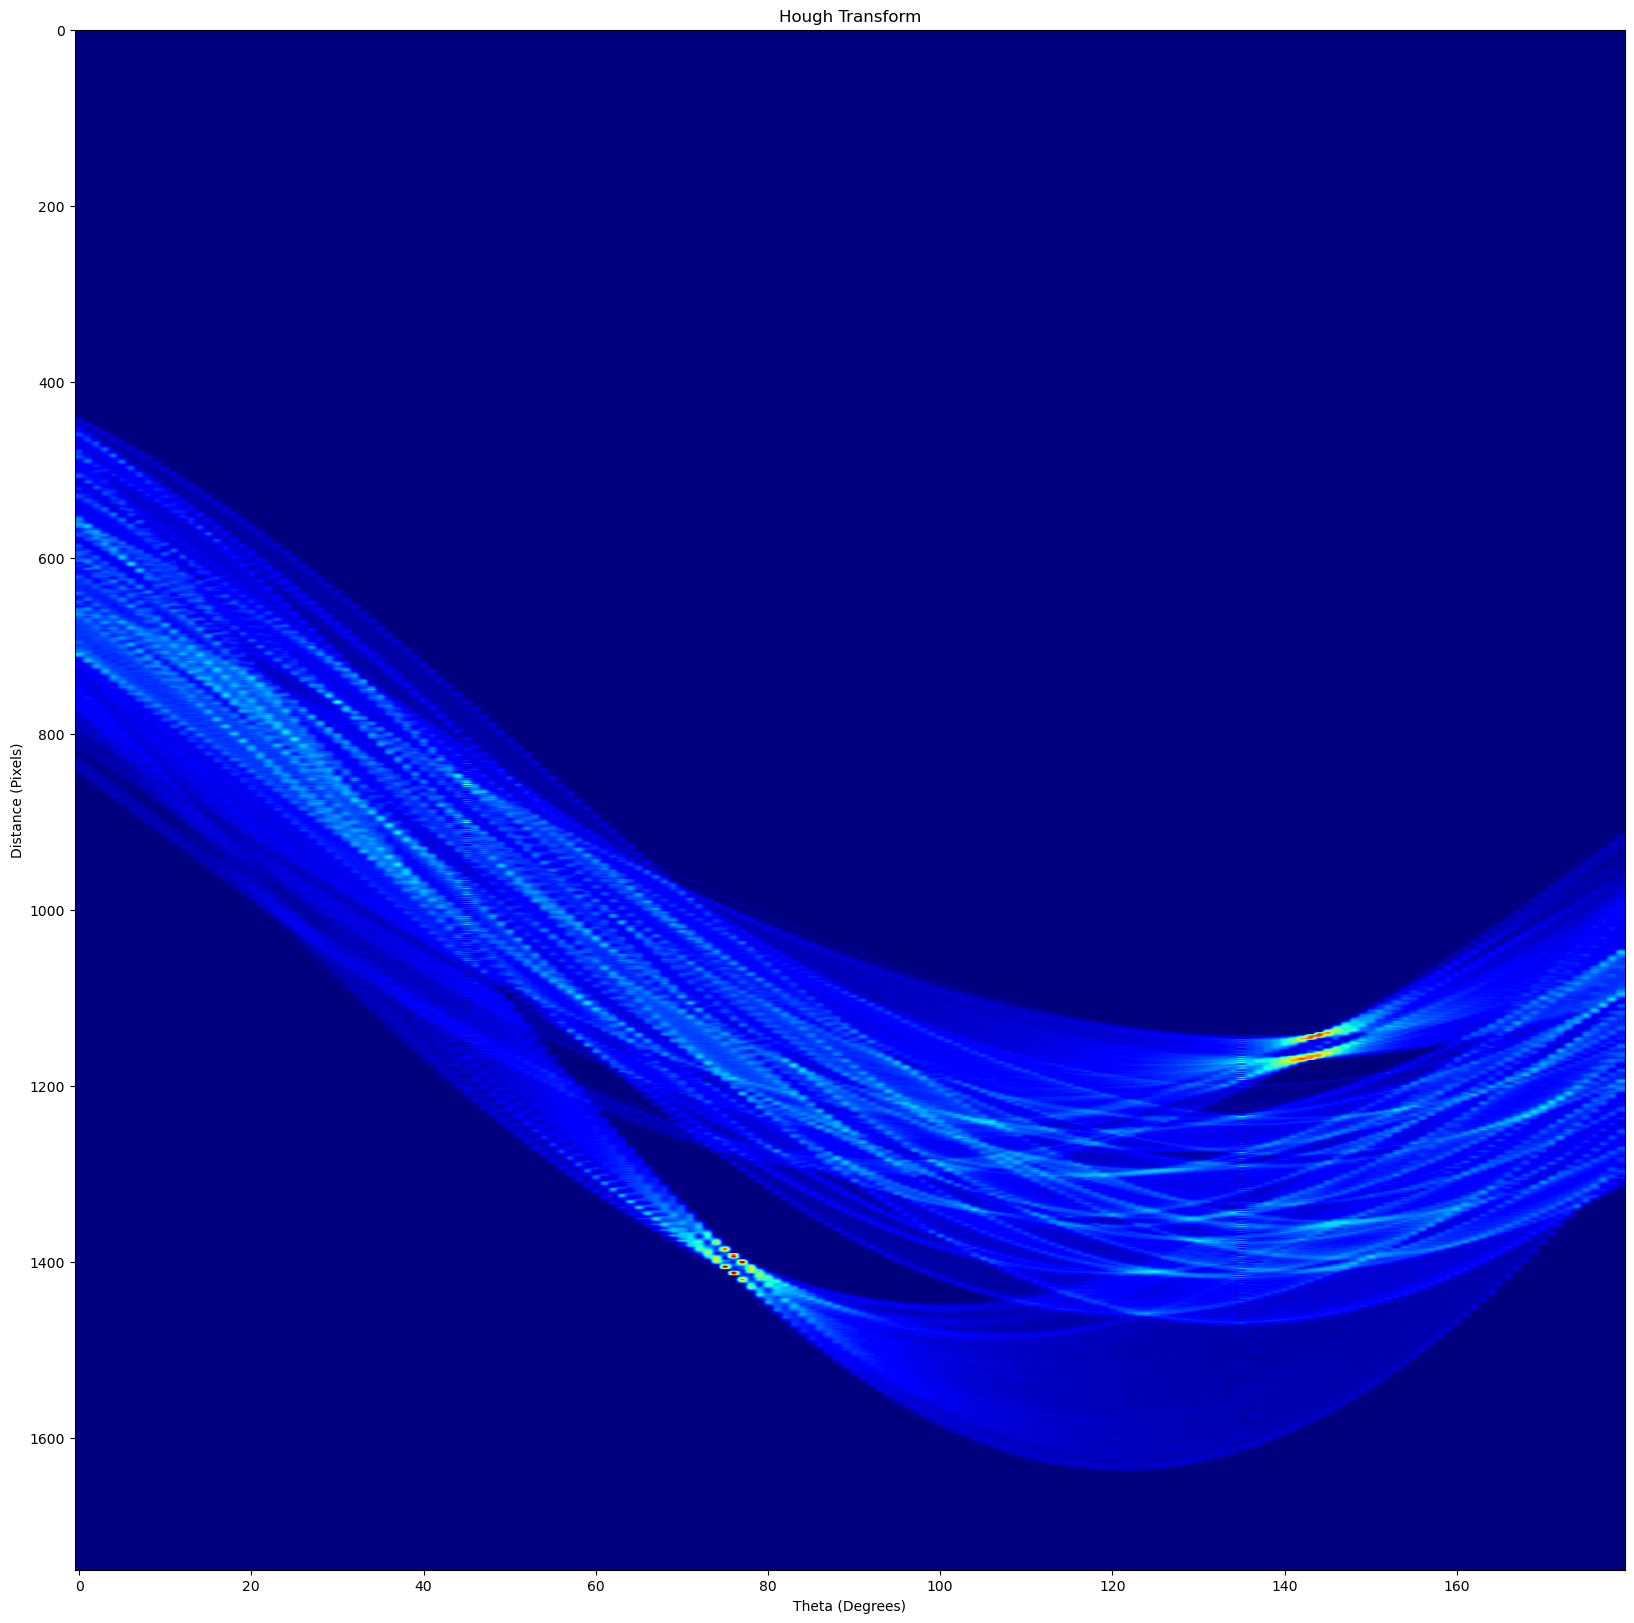

In [157]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract the lines
# To expedite the process you can play with the resolution of the theta and rho 
# without compromising the quality of the results
diag_len = math.ceil(np.sqrt(img.shape[0]**2+img.shape[1]**2))
smooth_accumulator, smooth_thetas, smooth_rhos, smooth_binary_img = hough_transform(smooth_img_gray_edge, \
    np.max(smooth_img_gray_edge)/3.0, [-90, 90], [-diag_len, diag_len])

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_1/Smooth_Clean_Binary_Image.png', smooth_binary_img)

#Plot the Binary Image
plt.figure(); plt.imshow(smooth_binary_img.astype(np.uint8), cmap='gray'); plt.title('Binary Image') 

##############################
# TO DO: Your Implementation
##############################
plot_accum_arr(smooth_accumulator, save_path='../results/Ques_1/Smooth_Clean_Image_Accumulator_Array.png')
print(f"Response: The more exclusive our threshold or rather the more we ignore irrelevant edges \n"+ \
    "the faster the hough transform processes the accumulator.")
################################
# Your Implementation ENDS here
################################

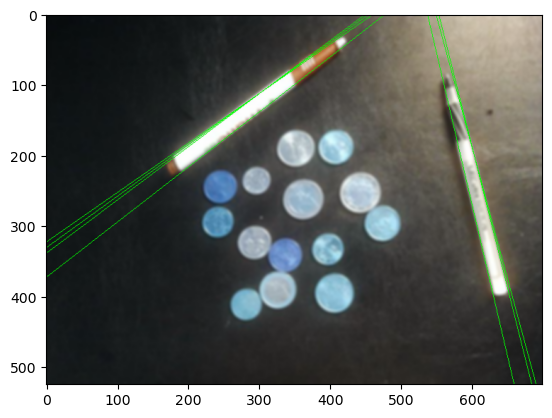

In [158]:
# Plot the Lines extracted on the Smooth Image
# Play with the Accumulator Thresholding to get rid of the unwanted lines
acc_threshold = np.max(smooth_accumulator)*0.8
plot_lines('../results/Ques_1/proj2-clean-image-smoothed.png', smooth_accumulator, smooth_thetas, smooth_rhos, acc_threshold, save_path='../results/Ques_1/Smooth_Clean_Image_Output_Lines.png')

#### 1.4 Hough Transform to detect Edges

Plot the Edges instead of Lines (infinite) along the boundary of the pens.

you should use the OpenCV <b>line</b> function which can hold all the edges and you could then overlay them on the input image.

In [166]:
def plot_edges(img_path, accumulator, thetas, rhos, acc_threshold, binary_image, save_path):

    '''
    This function plots edges
    This should be used to draw edges along the boundary of the pens
    
    Input:
    1. RGB Image for plotting lines
    2. Accumulator array
    3. Vector of the angle values
    4. Vector of the rho values
    5. Threshold value for selecting lines from the accumulator
    6. Path to save the image with lines drawn on them
    
    '''
    ##############################
    # TO DO: Your Implementation
    ##############################
    img = cv.imread(img_path)
    m = 500
    
    acc_threshold_vals = np.int32(accumulator >= acc_threshold)*accumulator
    max_idxs = np.argmax(acc_threshold_vals, 0)
    nz_idxs = np.nonzero(max_idxs)[0]
    for t_idx in nz_idxs:
        rho, theta = rhos[max_idxs[t_idx]], thetas[t_idx]   
        
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        x0, y0 = cos_t*rho, sin_t*rho
        pt0, pt1 = (round(x0 + -sin_t*m), round(y0 + cos_t*m)), (round(x0 + sin_t*m), round(y0 - cos_t*m))
        cv.line(img, pt0, pt1, (0, 255, 0), 3, cv.LINE_AA)
        
    plt.figure();plt.imshow(img, aspect='auto')
    cv.imwrite(save_path, img)
    
    ################################
    # Your Implementation ENDS here
    ################################

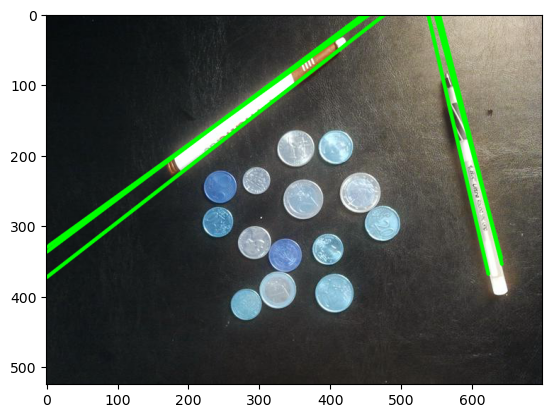

In [167]:
# Plot the Boundaries of the Pen on the Real Image
# This unlike the previous result is restricted to a finite length line
# Play with the Accumulator Thresholding to get rid of the unwanted lines
acc_threshold = np.max(ori_accumulator)*0.5
plot_edges('../data/proj2-clean-image.jpg', ori_accumulator, ori_thetas, ori_rhos, acc_threshold, ori_binary_img, save_path='../results/Ques_1/Ori_Clean_Image_Output_Edges.png')

In [ ]:
# Plot the Boundaries of the Pen on the Smooth Image
# This unlike the previous result is restricted to a finite length line
# Play with the Accumulator Thresholding to get rid of the unwanted lines

plot_edges('../results/Ques_1/proj2-clean-image-smoothed.png', smooth_accumulator, smooth_thetas, smooth_rhos, acc_threshold, smooth_binary_img, save_path='../results/Ques_1/Smooth_Clean_Image_Output_Edges.png')

### 2. Hough Transform to detect Circles (12 points)
In this exercise you are expected to implement Hough Transform for circle detection in images as discussed in class. Hough Transform uses an accumulator array to capture the circles present in image. As a circle could be defined with three parametrs, center (along X and Y axis) and radius, we need a three-dimensional accumulator to store the circle information.

#### Tasks:
1. Hough Transform to detect circles from the Images <b>(8 points)</b>
2. Plot the detected circles on the corresponding images <b>(4 points)</b>

You need to perform the task on the <b>Original Image</b> and <b>Smooth Image</b> computed earlier.

It is applied on <b>binary images</b> which can be generated by thresholding the edge detector output.<br>
You should use the result of the previous edge detection task as input for this exercise.

<b>The center of the circle should be computed using the parametric equations.</b>

In [ ]:
def circle_hough_transform(input_img, threshold, min_radius, max_radius, radius_res, angle_res):

    '''
    This function computes the accumulator array with the circles
    detected in the image
    
    Input:
    1. Output of the Edge Detection Method
    2. Threshold value for generating the binary image
    3. Min Radius of the Circle to be detected
    4. Max Radius of the Circle to be detected
    5. Resolution for Circle Radius
    6. Angle resolution for parametric equation of circle
    
    Output:
    1. Accumulator array          , declare as accumulator
    2. Array for Circle Center    , declare as center_x_vector, center_y_vector
    3. Array for Radius of Circle , declare as radius_vector
    4. Thresholded Binary Image   , declare as binary_img

    '''

    ############################
    # To DO: Your Implementation
    ############################

    
    ################################
    # Your Implementation ENDS here
    ################################

    return accumulator, radius_vector, center_x_vector, center_y_vector, binary_img


#### 2.1.1 Hough Transform to detect Circles from the Original Image

Use the edges detected from the <b>original input image</b> to apply Hough Transform function.<br>

You need to find a resaonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract circles. Please discuss the effect of the threshold on the performance of the algorithm.

##### Please note that you should be able to extract atleast 7 coins. This ensures 75% of the credit.

In [ ]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

ori_circle_accumulator, ori_circle_radius_vector, ori_circle_center_x_vector, ori_circle_center_y_vector, ori_circle_img_bin = circle_hough_transform(img_gray_edge, threshold, min_radius, max_radius, radius_res, angle_res)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_2/Ori_Clean_Binary_Image_Circle_Detection.png', ori_circle_img_bin)

#### 2.1.2 Hough Transform to detect Circles from the Smooth Image

Use the edges detected from the <b>smooth input image</b> to apply Hough Transform function or generate a suitable smooth image (following the same procedure) for this exercise to detect coins. If you generate a new smooth image please save the generated image as <b>proj2-clean-image-smoothed-circle-detection.png</b>.<br>

You should explain the reason for generating a new smooth image, report the value of sigma and discuss its effect on the performance of the circle detection algorithm.<br>
<br>
You need to find a resaonable estimate of the threshold for generating the binary image
which is good enough for the Hough transform to extract circles. Please discuss the effect of the threshold on the performance of the algorithm.<br>

##### Please note that you should be able to extract atleast 7 coins. This ensures 75% of the credit.

In [ ]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract circles
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

smooth_circle_accumulator, smooth_circle_radius_vector, smooth_circle_center_x_vector, smooth_circle_center_y_vector, smooth_circle_img_bin = circle_hough_transform(smooth_img_gray_edge, threshold, min_radius, max_radius, radius_res, angle_res)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_2/Smooth_Clean_Binary_Image_Circle_Detection.png', smooth_circle_img_bin)

#### 2.2 Plot the Circles around the coins in the image
You should use the OpenCV <b>circle</b> function for drawing circles. This can hold all the circles and then you could overlay them on the input image.

In [ ]:
def plot_circles(img_path, accumulator, radius_vector, center_x_vector, center_y_vector, acc_threshold, bin_image, img_save_path):

    '''
    This function plots cirles
    This should be used to draw lines along the boundary of the pens
    
    Input:
    1. RGB Image for plotting circles
    2. Accumulator array
    3. Vector of the radius values
    4. Vector of the center of the circle
    5. Threshold value for selecting lines from the accumulator
    6. Path to save the image with lines drawn on them
    
    Output:
    Returns Nothing
    Saves the output image in save_path
    '''
    
    ##############################
    # TO DO: Your Implementation
    ##############################


    ################################
    # Your Implementation ENDS here
    ################################
        
    # All the changes made in the input image are finally
    # written on a new file
    cv.imwrite(img_save_path, cv_img)


#### 2.2.1 Plot the Circles around the coins in the Original Image

Play with the Accumulator Thresholding to get rid of unwanted circles.


In [ ]:
# Plot the Circles extracted on the Original Image

plot_circles('../data/proj2-clean-image.jpg', ori_circle_accumulator, ori_circle_radius_vector, ori_circle_center_x_vector, ori_circle_center_y_vector, acc_threshold, ori_circle_img_bin, '../results/Ques_2/Ori_Clean_Image_Output_Circles.png')

#### 2.2.2 Plot the Circles around the coins in the Smooth Image

Play with the Accumulator Thresholding to get rid of unwanted circles.


In [ ]:
# Plot the Circles extracted on the Smooth Image

plot_circles('../results/Ques_1/proj2-clean-image-smoothed.png', smooth_circle_accumulator, smooth_circle_radius_vector, smooth_circle_center_x_vector, smooth_circle_center_y_vector, acc_threshold, smooth_circle_img_bin, '../results/Ques_2/Smooth_Clean_Image_Output_Circles.png')

### 3 Hough Transform to detect Lines from Cluttered Image (15 points)
In this exercise you are expected to implement Hough Transform for line detection from cluttered image. Hough Transform uses an accumulator array to capture the lines present in image. It is applied on binary images which can be generated by thresholding the edge detector output.

#### Tasks:
1. Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the lines. Save the smooth image as <b>clutter_smooth_img</b>, numpy array. <b>(2 points)</b>
2. Identify the edges in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. Save the numpy array as <b>clutter_smooth_img_gray_edge</b>. <b>(2 points)</b>
3. Identify the lines in the Image using Hough Transform. <b>(2 points)</b>
4. Draw the detected lines. <b>(2 points)</b>
5. Likely the last produced several lines which DO NOT repesent the boundary of the pens. How do you take care of the probem? <b>(2 points)</b>
6. Find the lines which represents only the boundary of the pens. <b>(5 points)</b>

#### 3.1 Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the lines. Save the smooth image as clutter_smooth_img, numpy array.

In [ ]:
# Reading the Input Image
clutter_img        = cv.imread('../data/proj2-clutter-image.jpg')

##############################
# TO DO: Your Implementation
##############################


################################
# Your Implementation ENDS here
################################

# Saves the Smooth Image in the result directory
cv.imwrite("../results/Ques_3/clutter_smooth_img.png", clutter_smooth_img)

# Plots the smoothed image in the notebook
plt.figure(); plt.imshow(clutter_smooth_img.astype(np.uint8));

#### 3.2 Identify the edges in the smooth image, generated in the previous step. You can use the solution of Ques 1.2. Save the numpy array as clutter_smooth_img_gray_edge.

In [ ]:
##############################
# TO DO: Your Implementation
##############################

################################
# Your Implementation ENDS here
################################

# Save the Image
cv.imwrite('../results/Ques_3/clutter_smooth_img_gray_edge.png', clutter_smooth_img_gray_edge)

#Plot the Image
plt.figure(); plt.imshow(clutter_smooth_img_gray_edge.astype(np.uint8), cmap='gray');

#### 3.3 Identify the lines in the Image using Hough Transform

In [ ]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract the lines
# To expedite the process you can play with the resolution of the theta and rho 
# without compromising the quality of the results

clutter_smooth_accumulator, clutter_smooth_thetas, clutter_smooth_rhos, clutter_smooth_binary_img = hough_transform(clutter_smooth_img_gray_edge, threshold, theta_res, rho_res)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_3/Clutter_Smooth_Binary_Image.png', clutter_smooth_binary_img)

#Plot the Binary Image
plt.figure(); plt.imshow(clutter_smooth_binary_img.astype(np.uint8), cmap='gray'); plt.title('Binary Image')

#### 3.4 Draw the detected lines

In [ ]:
# Plot the Lines extracted on the Original Image
# Play with the Accumulator Thresholding to get rid of the unwanted lines

plot_lines('../results/Ques_3/Clutter_Smooth_Binary_Image.png', clutter_smooth_accumulator, clutter_smooth_thetas, clutter_smooth_rhos, acc_threshold, save_path='../results/Ques_3/Clutter_Smooth_Image_Output_Lines.png')

#### 3.5 Most likely the last exercise produced several lines which DO NOT repesent the boundaries of the pens. How do you take care of the probem? Discuss.

#### 3.6 Find the edges which represents only the boundaries of the pens and plot it on the smooth version of the clutter image. 
You need to write a function similar to plot_edges() (but NOT the same).  You will need to check the length of each segment of the line and select only the ones that are above a certain threshold length.  

Save the output image as <b>'../results/Ques_3/Clutter_Smooth_Image_Output_Edges.png'</b>

In [ ]:
##############################
# TO DO: Your Implementation
##############################

################################
# Your Implementation ENDS here
################################

### 4. Hough Transform to detect Circles from Cluttered Image (17 points)
In this exercise you are expected to implement Hough Transform for detecting circles from cluttered image. Hough Transform is applied on binary images which can be generated by thresholding the edge detector output.

#### Tasks:
1. Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the circles. Save the smooth image as <b>clutter_smooth_img_circle_detection</b>, numpy array. <b>(2 points)</b>
2. Identify the edges in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. Save the numpy array as <b>clutter_smooth_img_gray_edge_circle_detection</b>. <b>(2 points)</b>
3. Identify the circles in the Image using Hough Transform. <b>(2 points)</b>
4. Draw the detected circles. <b>(2 points)</b>
5. Did the last solution detect any unwanted circles? If yes, please explain the reason. Which parameters you feel are affecting the result. Moreover, what could be the correct measures to prevent this? <b>(5 points)</b>
6. You are required to find boundaries around atleast 8 coins in the image. <b>(4 points)</b>

#### 4.1 Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the circles. Save the smooth image as <b>clutter_smooth_img_circle_detection</b>, numpy array.

In [ ]:
# Reading the Input Image
clutter_img_circle_detection        = cv.imread('../data/proj2-clutter-image.jpg')

##############################
# TO DO: Your Implementation
##############################



################################
# Your Implementation ENDS here
################################

# Saves the Smooth Image in the result directory
cv.imwrite("../results/Ques_4/proj2-clutter-image-smoothed_circle_detection.png", clutter_smooth_img_circle_detection)

# Plots the smoothed image in the notebook
plt.figure(); plt.imshow(clutter_smooth_img_circle_detection.astype(np.uint8));

#### 4.2 Identify the circles in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. 
Save the numpy array as <b>clutter_smooth_img_gray_edge_circle_detection</b>.

In [ ]:
##############################
# TO DO: Your Implementation
##############################



################################
# Your Implementation ENDS here
################################

# Save the Image
cv.imwrite('../results/Ques_4/Smooth_Clutter_Edge_Image_Circle_Detection.png', clutter_smooth_img_gray_edge_circle_detection)

#Plot the Image
plt.figure(); plt.imshow(clutter_smooth_img_gray_edge.astype(np.uint8), cmap='gray');

#### 4.3 Identify the circles in the Image using Hough Transform

In [ ]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract circles
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

clutter_smooth_circle_accumulator, clutter_smooth_circle_radius_vector, clutter_smooth_circle_center_x_vector, clutter_smooth_circle_center_y_vector, clutter_smooth_circle_img_bin = circle_hough_transform(clutter_smooth_img_gray_edge_circle_detection, threshold, min_radius, max_radius, radius_res, angle_res)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_4/Smooth_Clutter_Binary_Image_Circle_Detection.png', clutter_smooth_circle_img_bin)

#### 4.4 Draw the detected circles

In [ ]:
# Plot the Circles extracted on the Smooth Image

plot_circles('../results/Ques_4/proj2-clutter-image-smoothed_circle_detection.png', clutter_smooth_circle_accumulator, clutter_smooth_circle_radius_vector, clutter_smooth_circle_center_x_vector, clutter_smooth_circle_center_y_vector, acc_threshold, clutter_smooth_circle_img_bin, '../results/Ques_4/Smooth_Clutter_Image_Output_Circles.png')

#### 4.5 Did the last solution detect any unwanted circles? If yes, please explain the reason. Which parameters you feel are affecting the result. Moreover, what could be the correct measures to prevent this?

#### 4.6 Devise some mechanisms such that you can find boundaries of at least 8 coins in the image

In [ ]:
##############################
# TO DO: Your Implementation
##############################



################################
# Your Implementation ENDS here
################################

### 5 Test Robustness to Noise (15 points)
In this exercise, we test the robustness of Hough Transform to Gaussian noise.<br>
For this experiment, consider the optimum setting of the parameters (like sigma for smoothing, threshold for binary image, threshold for accumulator and others) for both line and circle detection using Hough Transform.<br>

Then keep adding Gaussian noise to the clutter image, <b>proj2-clutter-image.jpg</b>, starting with sigma value of 5.0 and doubling the sigma at every step, until the detection of lines and circles substantially fails. Mark this value as the of sigma as the failure sigma value.<br>

Between the starting sigma value i.e., 5.0 and the failure sigma value, show sequence of 5 images (equally spaced as per the number of steps) with the detected lines and circles drawn on them where each image represents different sigma value for the Gaussian noise.<br>

With failure sigma value as noise parameter, generate the noisy image and determine a smoothing filter (Gaussian filter as used earlier) to detect lines and circles from the noisy image. Do not change any other parameters used for extraction of lines and circles.

#### Task
1. Starting with sigma value of 5.0 and doubling the sigma at every step determine the sigma when the line and circle detection using Hough Transform fails. <b>(7 points)</b>
2. Plot sequence of 5 images (equally spaced as per the number of steps) with the detected lines or circles drawn on them where each image represents different sigma value for the Gaussian noise. Save the output images separately for circles and lines with the corresponding sigma values. <b>(5 points)</b>
3. Generate a smoothing filter that can handle the maximum noise and help in the detection of lines and circles from the noisy image. Keep the other parameters similar. Save the output images for circles and lines separately. <b>(3 points)</b>

#### Results:
All the output images should be saved in the directory <b>results/Ques_5/</b> with a meaningful name (as used in previous questions). Use the <b>imwrite</b> function in OpenCV library for saving images. You should use the OpenCV <b>line</b> and <b>circle</b> function to draw lines and circles respectively.  Make sure to save the noisy and filtered images you are generating.  

### 6 Hough Transform to detect Lines and Circles from a Distorted Image (15 points)
In this exercise you should use your Hough Transform implementation to try and detect lines and circles from the distorted image, <b>proj2-foreshortened-image.jpg</b>. Load the image from the data directory to do all the procesing to extract the lines and circles.


#### Tasks:
1. Plot the edges of the pens and boundaries of the coins, using the functions defined in the previous questions <b>(5 points)</b>
3. How many of the lines and edges in the image did your Hough transform detect? How many additional lines and circles do you see that weren't detected? What differences in appearance, shape, etc. do you notice between those that were and weren't detected? <b>(5 points)</b>
4. Discuss what changes to the alogirhtm you think could help in making the missed lines and circles visible? <b>(5 points)</b>

#### Results:
All the output images should be saved in the directory <b>results/Ques_6/</b> with a meaningful name (as used in previous questions). Use the <b>imwrite</b> function in OpenCV library for saving images. You should use the OpenCV <b>line</b> and <b>circle</b> function to draw lines and circles respectively.